In [1]:
import astropy.units as u
import astropy.io.fits
import astropy.time
import astropy.table
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface

from IPython.display import HTML

%matplotlib inline

Define some needed functions for querying data and making cutouts

In [6]:
def search_registry(start_date, end_date, wavelength, bucket=None):
    import scregistry
    if bucket is None:
        bucket = "s3://gov-nasa-hdrl-data1/"
    file_registry = scregistry.FileRegistry(bucket)
    results =  file_registry.request_file_registry(
        f'aia_{int(wavelength.to_value("angstrom")):04d}',
        start_date=f'{start_date.isot}Z',
        stop_date=f'{end_date.isot}Z',
        overwrite=False
    )
    results = astropy.table.Table.from_pandas(results)
    return results


def map_from_s3_file(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        header = hdul[1].header
        data = hdul[1].data
    return sunpy.map.Map(data, header)


def cutout_from_s3_file(filename, center, fov, use_subsetting=False):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}, lazy_load_hdus=True) as hdul:
        wcs = astropy.wcs.WCS(hdul[1].header)
        data = hdul[1].section if use_subsetting else hdul[1].data
        with propagate_with_solar_surface():
            cutout = Cutout2D(data, center, fov, wcs=wcs)
    return sunpy.map.Map(cutout.data, cutout.wcs)


def reproject_cutout(smap, wcs_ref, center, fov):
    with propagate_with_solar_surface():
        smap_repr = smap.reproject_to(wcs_ref)
    cutout = Cutout2D(smap_repr.data, center, fov, wcs=smap_repr.wcs)
    return sunpy.map.Map(cutout.data, cutout.wcs, )

## Searching for data

First, define the wavelengths we want to search over and the time range

In [7]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')

In [8]:
file_list = search_registry(midpoint-interval/2, midpoint+interval/2, 171*u.angstrom)

## Identifying the Active Region

Next, we need to identify where our active region is on the disk.
We do this at a specific time that is approximately the midpoint of our observing interval.
We can then load in our full-disk map, identify the active region of interest, and create the bounding box to make the rest of our cutouts.

In [10]:
i_midpoint = np.argmin(np.fabs((file_list['start'] - midpoint).to_value('s')))

In [11]:
ref_map_full_disk = map_from_s3_file(file_list['datakey'][i_midpoint])

In [12]:
ar_center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=ref_map_full_disk.coordinate_frame)

To confirm this, we can plot map and the coordinate of the active region center.

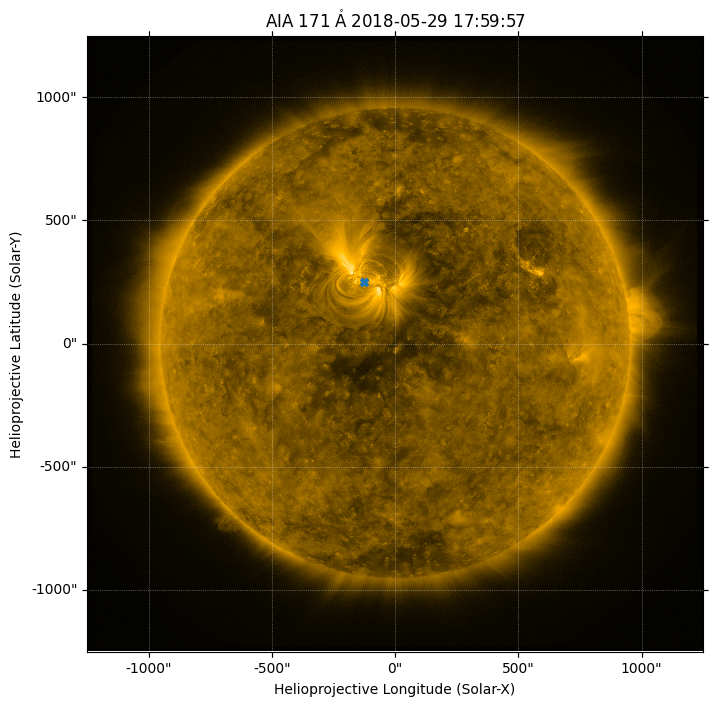

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ref_map_full_disk)
ref_map_full_disk.plot(axes=ax)
ax.plot_coord(ar_center, marker='X', color='C0')

Next, we want to create a cutout around the active region.
This will help us define our bounding box for the rest of our cutouts.

In [15]:
fov_expanded = (600,800)*u.arcsec

In [16]:
with propagate_with_solar_surface():
    cutout = Cutout2D(ref_map_full_disk.data, ar_center, fov_expanded, wcs=ref_map_full_disk.wcs)
ref_map_cutout = sunpy.map.Map(cutout.data, cutout.wcs, plot_settings=ref_map_full_disk.plot_settings)

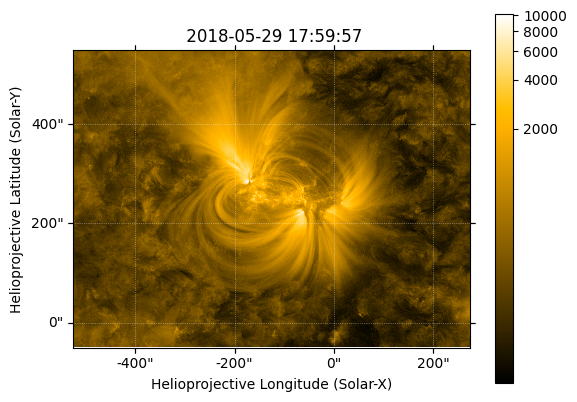

In [17]:
ref_map_cutout.peek()

## Cropping All Maps

Now that we've identified our region of interest, we can crop all of our maps at each timestep to this same field of view.

In [19]:
cutouts_171 = [cutout_from_s3_file(f, ar_center, fov_expanded,) for f in file_list['datakey'][::20]]

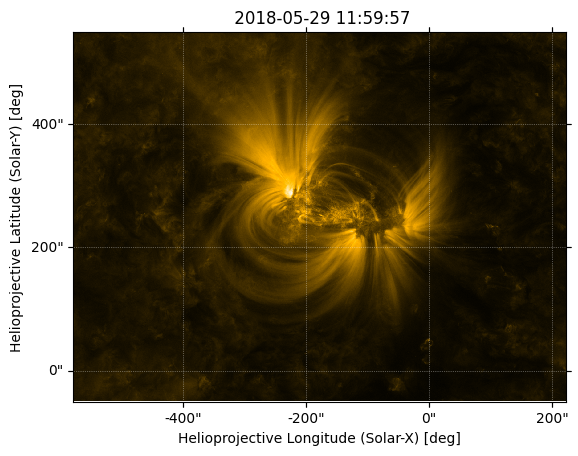

In [29]:
HTML(sunpy.map.Map(cutouts_171, sequence=True).plot(cmap='sdoaia171', norm=ImageNormalize(vmin=1, vmax=1e4, stretch=AsinhStretch())).to_jshtml())

In [30]:
time_171 = astropy.time.Time([m.date for m in cutouts_171])
time_171 = (time_171 - time_171[0]).to('s')

## Reprojecting Cutouts

In [31]:
fov = 500*u.arcsec

In [32]:
cutouts_reprojected_171 = [reproject_cutout(m, ref_map_cutout.wcs, ar_center, fov) for m in cutouts_171]

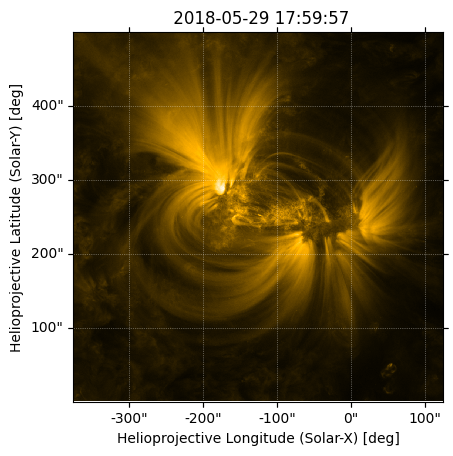

In [33]:
HTML(sunpy.map.Map(cutouts_reprojected_171, sequence=True).plot(cmap='sdoaia171', norm=ImageNormalize(vmin=1, vmax=1e4, stretch=AsinhStretch())).to_jshtml())

## Sandbox

In [31]:
import astropy.utils.data

In [40]:
with astropy.io.fits.open(astropy.utils.data.get_pkg_data_filename('galactic_center/gc_msx_e.fits')) as hdul:
    data = hdul[0].data
    header = hdul[0].header

In [56]:
gal_frame = astropy.wcs.utils.wcs_to_celestial_frame(astropy.wcs.WCS(header))
coord = SkyCoord(0*u.deg, 0*u.deg, frame=gal_frame)

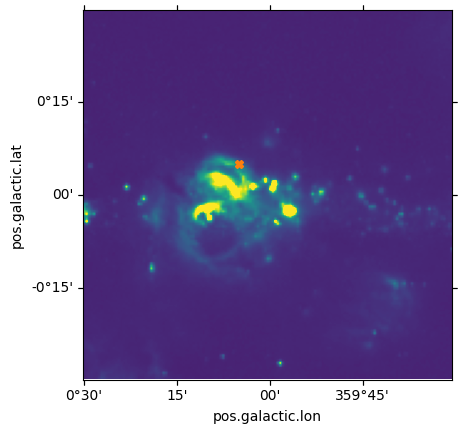

In [55]:
fig = plt.figure()
ax = fig.add_subplot(projection=astropy.wcs.WCS(header))
ax.imshow(data, vmin=-2.e-5, vmax=2.e-4, origin='lower')
ax.plot_coord(coord, marker='X', color='C1')

In [52]:
astropy.io.fits.CompImageHDU(data=data, header=header).writeto('foo_compressed.fits', overwrite=True)

In [61]:
data.shape

(149, 149)

In [68]:
with astropy.io.fits.open('foo_compressed.fits') as hdul:
    header = hdul[1].header
    #_ = Cutout2D(hdul[1].data, (75,75), 100*u.pix,)
    data = hdul[1].section[25:125,25:125]

In [69]:
data

array([[3.25008001e-06, 4.65274611e-06, 4.34484380e-06, ...,
        1.14265971e-05, 1.16318653e-05, 1.20424017e-05],
       [4.27944082e-06, 4.04811970e-06, 5.32038589e-06, ...,
        1.20672520e-05, 1.16431633e-05, 1.22600197e-05],
       [3.02121542e-06, 3.58769332e-06, 4.90947506e-06, ...,
        1.07630799e-05, 1.13295578e-05, 1.13295578e-05],
       ...,
       [3.42588422e-06, 1.76647155e-06, 2.83706037e-06, ...,
        3.26529590e-06, 2.40882484e-06, 3.47941366e-06],
       [2.13738086e-06, 8.38188574e-07, 4.61003716e-07, ...,
        1.63446772e-06, 6.28641431e-07, 2.55647515e-06],
       [1.29228696e-06, 2.58457391e-06, 2.83309063e-06, ...,
        3.47923411e-07, 2.58457391e-06, 1.88872709e-06]])